In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn # neural network
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load data from csv
file_path = '/content/drive/MyDrive/Colab Notebooks/OddSemester2024/MINI PROJECT/Data/Test_Signal_Data.csv'
data = pd.read_csv(file_path)

In [ ]:
# define the data driven model that has a neural network (feed forward neural network) to predict Tr and Tj
class data_driven_model(nn.Module):
    def __init__(self):  # Initialize layers as before
        super(data_driven_model, self).__init__()
        self.fc1 = nn.Linear(5, 64)  # 5 inputs: I, M, Tr, Tj, Fc
        self.fc2 = nn.Linear(64, 64) # 2 hidden layers
        self.fc3 = nn.Linear(64, 2)  # Now output is 2 values: Tr and Tj

    def forward(self, x):
        x = torch.relu(self.fc1(x)) # relu activation function
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Outputs: Tr_pred, Tj_pred
        return x

In [ ]:
# Instantiate the model and define adam optimizer and loss function (mse loss)
model = data_driven_model()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.MSELoss()

In [ ]:
# define constants and parameters for the batch reactor equations
Ad = 4.4e16
Ed = 140.06e3
Ap = 1.7e11 / 60
Ep = 16.9e3 / 0.239
deltaHp = -82.2e3
UA = 33.3083
Qc = 650
Qs = 12.41e-2
V = 0.5
Tc = 27
Cpc = 4.184
R = 8.3145
alpha = 1.212827
beta = 0.000267
m1 = 450
cp1 = 4.184
cp2 = 187
cp3 = 110.58
cp4 = 84.95
m5 = 220
cp5 = 0.49
m6 = 7900
cp6 = 0.49
M0 = 0.7034
I0 = 4.5e-3
mjCpj = 18 * cp1 + 240 * cp5

In [ ]:
# define first principle model to calculate temperatures Tr and Tj using auto-differentiation (tr_physics_grad_values and tj_physics_grad_values respectively)
def first_principle_model(data):

    # to store the values of tr and tj after auto differentiation is applied
    tr_physics_grads, tj_physics_grads = [], []

    for i in range(len(data)):
        Ii = torch.tensor(I0, dtype = torch.float32, requires_grad = True)
        M = torch.tensor(M0, dtype = torch.float32, requires_grad = True)
        Tr = torch.tensor(data['Tr'].iloc[i], dtype = torch.float32, requires_grad = True)
        Tj = torch.tensor(data['Tj'].iloc[i], dtype = torch.float32, requires_grad = True)
        Fc = torch.tensor(data['Fc'].iloc[i], dtype = torch.float32, requires_grad = True)
        F = Fc * 16.667

        # Reaction rates (Ri and Rp)
        Ri = Ad * Ii * torch.exp(-Ed / (R * (Tr + 273.15)))
        Rp = Ap * (Ii ** alpha) * (M ** beta) * torch.exp(-Ep / (R * (Tr + 273.15)))

        # Heat capacity terms
        mrCpr = m1 * cp1 + Ii * cp2 * V + M * cp3 * V + (M0 - M) * cp4 * V + m5 * cp5 + m6 * cp6
        Qpr = alpha * (Tr - Tc) ** beta

        # Calculate true values of Tr and Tj
        Tr_phy =  (Rp * V * (-deltaHp) - UA * (Tr - Tj) + Qc + Qs - Qpr) / mrCpr
        Tj_phy =  (UA * (Tr - Tj) - F * Cpc * (Tj - Tc)) / mjCpj

        # auto differentiation is applied to the equations of Tr and Tj
        # since our auto differentiated value of Tr and Tj is seen to be very small, we are adding it to the actual Tr and Tj values
        Tr_physics_grad = Tr + torch.autograd.grad(Tr_phy, Tr, retain_graph = True)[0]
        Tj_physics_grad = Tj + torch.autograd.grad(Tj_phy, Tj, retain_graph = True)[0]

        # print(f"Gradient of Tr_true with respect to Tr: {Tr_true_grad}")
        # print(f"Gradient of Tj_true with respect to Tj: {Tj_true_grad}")

        # tr_true_values.append(Tr_true.item())
        # tj_true_values.append(Tj_true.item())
        tr_physics_grads.append(Tr_physics_grad.item())
        tj_physics_grads.append(Tj_physics_grad.item())

    return (
        # torch.tensor(tr_true_values),
        # torch.tensor(tj_true_values),
        torch.tensor(tr_physics_grads),
        torch.tensor(tj_physics_grads),
    )


In [ ]:
#  Tr and Tj from first principle model
tr_physics_grad_values, tj_physics_grad_values = first_principle_model(data)

In [ ]:
# Prepare data for batch processing
I_values = torch.full((len(data),), I0).float()
M_values = torch.full((len(data),), M0).float()  # Constant M for all rows
Tr_values = torch.tensor(data['Tr'].values).float()
Tj_values = torch.tensor(data['Tj'].values).float()
Fc_values = torch.tensor(data['Fc'].values).float()
input_data = torch.stack([I_values, M_values, Tr_values, Tj_values, Fc_values], dim = 1)

In [ ]:
# Training loop to predict Tr and Tj with two separate loss functions
num_epochs = 2500
for epoch in range(num_epochs):
    # to get predicted Tr and Tj from data driven model
    predicted_temps = model(input_data)
    tr_predicted, tj_predicted = predicted_temps[:, 0], predicted_temps[:, 1]

    # Calculate separate losses for Tr and Tj
    l1_loss_tr = loss_fn(tr_predicted, tr_physics_grad_values)  # Loss for Tr - L1
    l2_loss_tj = loss_fn(tj_predicted, tj_physics_grad_values)  # Loss for Tj - L2

    # Combine the losses (sum) for backpropagation : this is the pinn loss
    pinn_loss = l1_loss_tr + l2_loss_tj

    # Zero out gradients from previous epoch
    optimizer.zero_grad()

    # Backpropagation
    # in this step, the loss is added to the data driven neural model equation as residue and whatever Tr and Tj is predicted from this is our final pinn values
    pinn_loss.backward()

    # Update model parameters
    optimizer.step()

    # Print separate losses every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss_Tr = {l1_loss_tr.item()}, Loss_Tj = {l2_loss_tj.item()}, PINN Loss = {pinn_loss.item()}")

Epoch 0: Loss_Tr = 4.5794454450742705e-08, Loss_Tj = 1.6444252182168384e-08, PINN Loss = 6.223870485655425e-08
Epoch 100: Loss_Tr = 3.5706847256733454e-08, Loss_Tj = 1.0128699656775098e-08, PINN Loss = 4.583554868986539e-08
Epoch 200: Loss_Tr = 9.554678399581462e-06, Loss_Tj = 0.00021243334049358964, PINN Loss = 0.0002219880116172135
Epoch 300: Loss_Tr = 1.9439008624999587e-08, Loss_Tj = 2.8157655762584e-08, PINN Loss = 4.759666438758359e-08
Epoch 400: Loss_Tr = 5.8568050008034334e-05, Loss_Tj = 0.0037031963001936674, PINN Loss = 0.003761764382943511
Epoch 500: Loss_Tr = 8.121118888482215e-09, Loss_Tj = 1.2347589972705464e-07, PINN Loss = 1.3159701950371527e-07
Epoch 600: Loss_Tr = 4.895161165308082e-09, Loss_Tj = 4.3536858562731595e-09, PINN Loss = 9.248847021581241e-09
Epoch 700: Loss_Tr = 2.7388227863411885e-07, Loss_Tj = 0.0002552521473262459, PINN Loss = 0.0002555260434746742
Epoch 800: Loss_Tr = 1.4825943805973907e-09, Loss_Tj = 1.8051455441536746e-08, PINN Loss = 1.9534049044978

In [ ]:
# the final set of temperatures predicted by our models (data driven model and first principle model) for Tr and Tj
print("Final Data Driven Predicted Temperatures (Tr, Tj) : ", predicted_temps.detach().numpy())
print()
print("Final First Principle Predicted Temperatures (Tr, Tj) : ", torch.stack([tr_physics_grad_values, tj_physics_grad_values], dim = 1).detach().numpy())
print()
print("Actual Tr and Tj values : ", torch.stack([Tr_values, Tj_values], dim = 1).detach().numpy())

Final Data Driven Predicted Temperatures (Tr, Tj) :  [[35.438686 30.894587]
 [34.941307 31.199343]
 [35.407597 31.25014 ]
 ...
 [59.40609  40.52867 ]
 [59.033054 40.503273]
 [59.095226 40.70645 ]]

Final First Principle Predicted Temperatures (Tr, Tj) :  [[35.438652 30.894487]
 [34.941277 31.199253]
 [35.407566 31.250046]
 ...
 [59.405968 40.52854 ]
 [59.032936 40.503147]
 [59.095108 40.70632 ]]

Actual Tr and Tj values :  [[35.444294 31.24789 ]
 [34.94692  31.552656]
 [35.413208 31.603449]
 ...
 [59.411594 40.746387]
 [59.038563 40.720993]
 [59.100735 40.924168]]


In [ ]:
# Extract the CSV values for Tr and Tj
csv_tr_values = torch.tensor(data['Tr'].values, dtype = torch.float32)
csv_tj_values = torch.tensor(data['Tj'].values, dtype = torch.float32)

# Convert tensors to numpy arrays for plotting
# actual vs predicted plots for Tr and Tj between the first principle model grad values and the true csv values
csv_tr_values = csv_tr_values.numpy()
csv_tj_values = csv_tj_values.numpy()
tr_pred_values_phy = tr_predicted.detach().numpy()
tj_pred_values_phy = tj_predicted.detach().numpy()

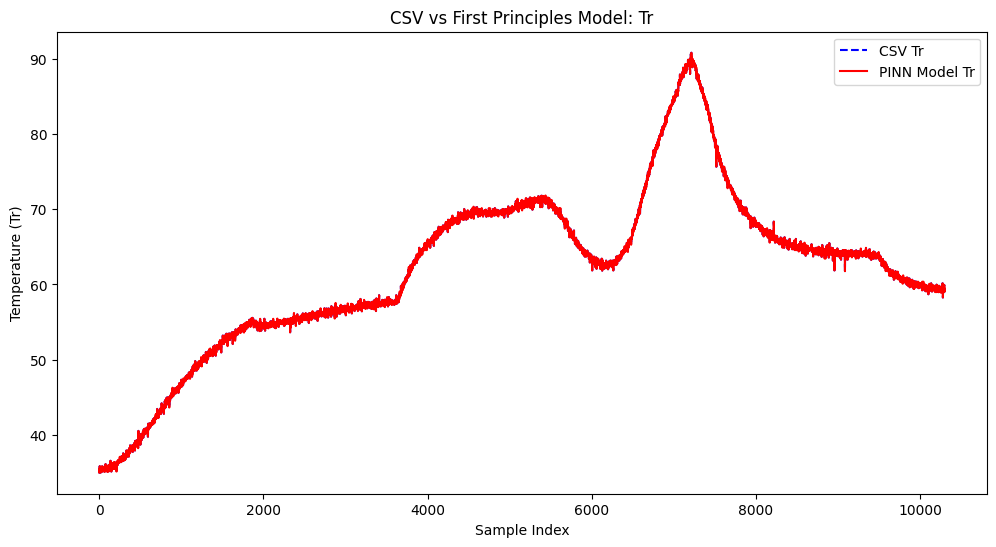

In [ ]:
# Plot for Tr: CSV values vs. PINN Model (Predicted)
plt.figure(figsize = (12, 6))
plt.plot(csv_tr_values, label = "CSV Tr", color = "blue", linestyle = "--")
plt.plot(tr_pred_values_phy, label = "PINN Model Tr", color = "red")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (Tr)")
plt.title("CSV vs First Principles Model: Tr")
plt.legend()
plt.show()

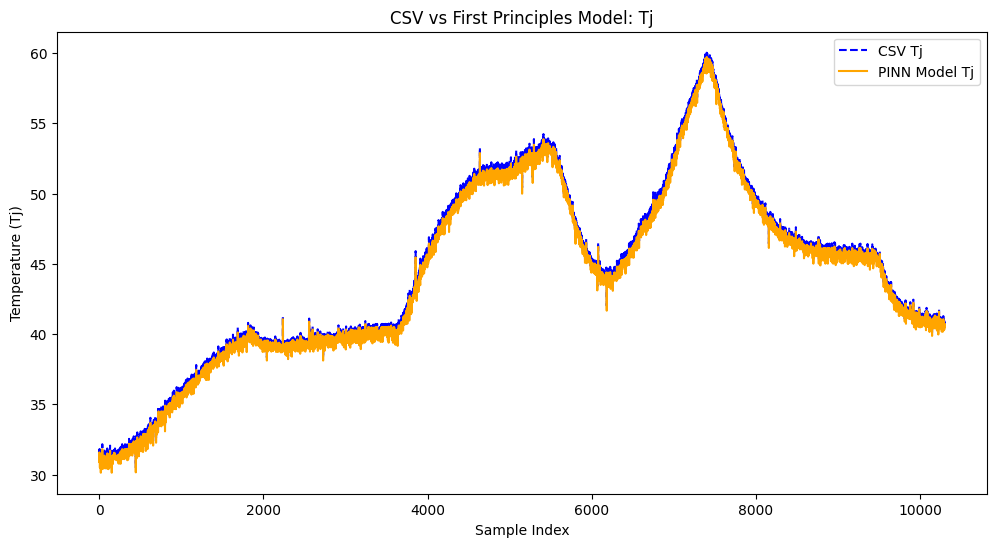

In [ ]:
# Plot for Tj: CSV values vs. PINN Model (Predicted)
plt.figure(figsize = (12, 6))
plt.plot(csv_tj_values, label = "CSV Tj", color = "blue", linestyle = "--")
plt.plot(tj_pred_values_phy, label = "PINN Model Tj", color = "orange")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (Tj)")
plt.title("CSV vs First Principles Model: Tj")
plt.legend()
plt.show()
